In [14]:
import pretty_midi
import numpy as np
import numba
import librosa
import soundfile as sf


import librosa.display
import matplotlib.pyplot as plt

sr = 44100

In [2]:
filename = 'Flower_Dance.mid'

In [3]:
midi_data = pretty_midi.PrettyMIDI(filename)
print(midi_data.estimate_tempo())

# audio_data = midi_data.fluidsynth(sr)
# sf.write('transcribed.wav',audio_data,sr,'PCM_32')


193.96352016608964


In [4]:
total_velocity = sum(sum(midi_data.get_chroma()))
print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

[0.14882466904816768, 0.006127463854772658, 0.09565674485336208, 0.0, 0.16759261992846294, 0.08340488444147769, 0.0033379099970515603, 0.1020957694680424, 0.01690495096349571, 0.2690256997368642, 0.0, 0.10702928770830306]


In [5]:
for instrument in midi_data.instruments:
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5
            
audio_data = midi_data.synthesize(sr)
sf.write('transcribed.wav',audio_data,sr,'PCM_32')

# 간단한 MIDI 파일 생성

In [6]:
cello_c_chord = pretty_midi.PrettyMIDI()
print(f'{cello_c_chord=}')

cello_program = pretty_midi.instrument_name_to_program('Cello')
print(f'{cello_program=}')

cello = pretty_midi.Instrument(program=cello_program)
print(f'{cello=}')


for note_name in ['C5','E5','G5']:
    note_number = pretty_midi.note_name_to_number(note_name)
    note = pretty_midi.Note(velocity=100, pitch=note_number, start=0, end=1)
    cello.notes.append(note)
note = pretty_midi.Note(velocity=100, pitch=0, start=0, end=1)
cello.notes.append(note)
note = pretty_midi.Note(velocity=100, pitch=12, start=0, end=1)
cello.notes.append(note)
print(f'{note=}')

cello_c_chord.instruments.append(cello)
cello_c_chord.write('cello-C-chord.mid')

cello_c_chord=<pretty_midi.pretty_midi.PrettyMIDI object at 0x000001CED13F7FD0>
cello_program=42
cello=Instrument(program=42, is_drum=False, name="")
note=Note(start=0.000000, end=1.000000, pitch=12, velocity=100)


In [7]:
cello_c_chord = pretty_midi.PrettyMIDI()
print(f'{cello_c_chord=}')

cello_program = pretty_midi.instrument_name_to_program('Cello')
print(f'{cello_program=}')

cello = pretty_midi.Instrument(program=cello_program)
print(f'{cello=}')

note_number = pretty_midi.note_name_to_number('C9') # 0옥타브 도
print(f'{note_number=}')

note = pretty_midi.Note(velocity=100, pitch=0, start=0, end=1)
cello.notes.append(note)
note = pretty_midi.Note(velocity=100, pitch=12, start=0, end=1)
cello.notes.append(note)

cello_c_chord.instruments.append(cello)
cello_c_chord.write('cello-C-chord.mid')

cello_c_chord=<pretty_midi.pretty_midi.PrettyMIDI object at 0x000001CED141D310>
cello_program=42
cello=Instrument(program=42, is_drum=False, name="")
note_number=120


# 피아노 롤 그리기

c:\Users\suo24\anaconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


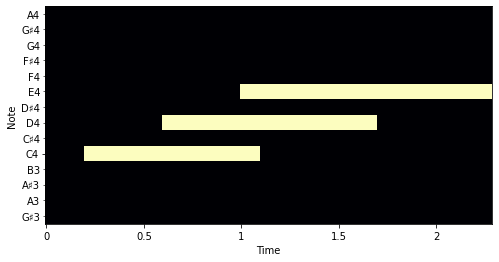

In [8]:
pm = pretty_midi.PrettyMIDI(initial_tempo=80)

inst = pretty_midi.Instrument(program=42, is_drum=False, name='my cello')
pm.instruments.append(inst)

velocity = 100
for pitch, start, end in zip([60, 62, 64], [0.2, 0.6, 1.0], [1.1, 1.7, 2.3]):
    inst.notes.append(pretty_midi.Note(velocity, pitch, start, end))

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs,
                             x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch)
                             )
plt.figure(figsize=(8,4))
plot_piano_roll(pm, 56, 70)

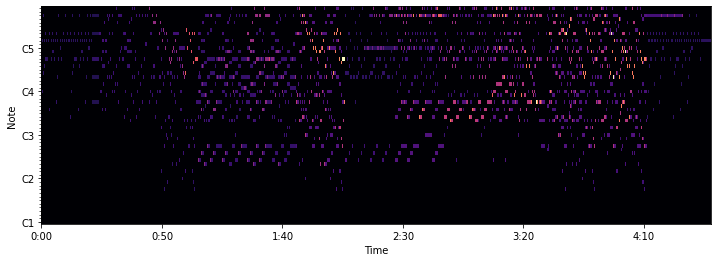

In [9]:
pm = pretty_midi.PrettyMIDI(filename)
plt.figure(figsize=(12,4))
plot_piano_roll(pm, 24, 84)

In [10]:
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument 3 has {} notes'.format(len(pm.instruments[0].notes)))
print('Instrument 4 has {} pitch bends'.format(len(pm.instruments[4].pitch_bends)))
print('Instrument 5 has {} control changes'.format(len(pm.instruments[5].control_changes)))

There are 1 time signature changes
There are 10 instruments
Instrument 3 has 338 notes
Instrument 4 has 0 pitch bends
Instrument 5 has 776 control changes


# Timing information

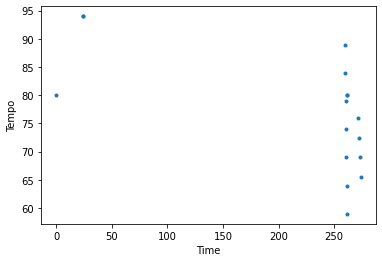

In [11]:
times, tempo_changes = pm.get_tempo_changes()
plt.plot(times, tempo_changes, '.')
plt.xlabel('Time')
plt.ylabel('Tempo');

c:\Users\suo24\anaconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


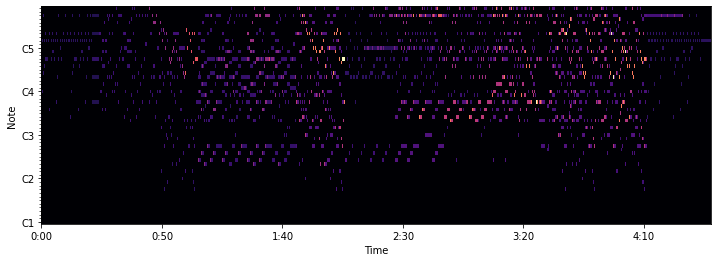

In [12]:
beats = pm.get_beats()
downbeats = pm.get_downbeats()

plt.figure(figsize=(12,4))
plot_piano_roll(pm, 24, 84)
ymin, ymax = plt.ylim()

In [13]:
def extract_cqt(audio_data, fs, hop, note_start, n_notes):
    cqt = librosa.cqt(
        audio_data, sr=fs, hop_length=hop,
        fmin=librosa.midi_to_hz(note_start), n_bins=n_notes)
    cqt = cqt.T
    cqt = librosa.amplitude_to_db(librosa.magphase(cqt)[0], ref=cqt.max())
    cqt = librosa.util.normalize(cqt, norm=2., axis=1)
    times = librosa.frames_to_time(np.arange(cqt.shape[0]), fs, hop)
    return cqt, times

# midi to wav

In [17]:
@numba.jit(nopython=True)
def band_mask(radius, mask):
    """Construct band-around-diagonal mask (Sakoe-Chiba band).  When
    ``mask.shape[0] != mask.shape[1]``, the radius will be expanded so that
    ``mask[-1, -1] = 1`` always.
    `mask` will be modified in place.
    Parameters
    ----------
    radius : float
        The band radius (1/2 of the width) will be
        ``int(radius*min(mask.shape))``.
    mask : np.ndarray
        Pre-allocated boolean matrix of zeros.
    Examples
    --------
    >>> mask = np.zeros((8, 8), dtype=np.bool)
    >>> band_mask(.25, mask)
    >>> mask.astype(int)
    array([[1, 1, 0, 0, 0, 0, 0, 0],
           [1, 1, 1, 0, 0, 0, 0, 0],
           [0, 1, 1, 1, 0, 0, 0, 0],
           [0, 0, 1, 1, 1, 0, 0, 0],
           [0, 0, 0, 1, 1, 1, 0, 0],
           [0, 0, 0, 0, 1, 1, 1, 0],
           [0, 0, 0, 0, 0, 1, 1, 1],
           [0, 0, 0, 0, 0, 0, 1, 1]])
    >>> mask = np.zeros((8, 12), dtype=np.bool)
    >>> band_mask(.25, mask)
    >>> mask.astype(int)
    array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
           [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
           [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
           [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
           [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
           [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
           [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
           [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])
    """
    nx, ny = mask.shape
    # The logic will be different depending on whether there are more rows
    # or columns in the mask.  Coding it this way results in some code
    # duplication but it's the most efficient way with numba
    if nx < ny:
        # Calculate the radius in indices, rather than proportion
        radius = int(round(nx*radius))
        # Force radius to be at least one
        radius = 1 if radius == 0 else radius
        for i in xrange(nx):
            for j in xrange(ny):
                # If this i, j falls within the band
                if i - j + (nx - radius) < nx and j - i + (nx - radius) < ny:
                    # Set the mask to 1 here
                    mask[i, j] = 1
    # Same exact approach with ny/ny and i/j switched.
    else:
        radius = int(round(ny*radius))
        radius = 1 if radius == 0 else radius
        for i in range(nx):
            for j in range(ny):
                if j - i + (ny - radius) < ny and i - j + (ny - radius) < nx:
                    mask[i, j] = 1


@numba.jit(nopython=True)
def dtw_core(dist_mat, add_pen, mul_pen, traceback):
    """Core dynamic programming routine for DTW.
    `dist_mat` and `traceback` will be modified in-place.
    Parameters
    ----------
    dist_mat : np.ndarray
        Distance matrix to update with lowest-cost path to each entry.
    add_pen : int or float
        Additive penalty for non-diagonal moves.
    mul_pen : int or float
        Multiplicative penalty for non-diagonal moves.
    traceback : np.ndarray
        Matrix to populate with the lowest-cost traceback from each entry.
    """
    # At each loop iteration, we are computing lowest cost to D[i + 1, j + 1]
    # TOOD: Would probably be faster if xrange(1, dist_mat.shape[0])
    for i in xrange(dist_mat.shape[0] - 1):
        for j in xrange(dist_mat.shape[1] - 1):
            # Diagonal move (which has no penalty) is lowest
            if dist_mat[i, j] <= mul_pen*dist_mat[i, j + 1] + add_pen and \
               dist_mat[i, j] <= mul_pen*dist_mat[i + 1, j] + add_pen:
                traceback[i + 1, j + 1] = 0
                dist_mat[i + 1, j + 1] += dist_mat[i, j]
            # Horizontal move (has penalty)
            elif (dist_mat[i, j + 1] <= dist_mat[i + 1, j] and
                  mul_pen*dist_mat[i, j + 1] + add_pen <= dist_mat[i, j]):
                traceback[i + 1, j + 1] = 1
                dist_mat[i + 1, j + 1] += mul_pen*dist_mat[i, j + 1] + add_pen
            # Vertical move (has penalty)
            elif (dist_mat[i + 1, j] <= dist_mat[i, j + 1] and
                  mul_pen*dist_mat[i + 1, j] + add_pen <= dist_mat[i, j]):
                traceback[i + 1, j + 1] = 2
                dist_mat[i + 1, j + 1] += mul_pen*dist_mat[i + 1, j] + add_pen


@numba.jit(nopython=True)
def dtw_core_masked(dist_mat, add_pen, mul_pen, traceback, mask):
    """Core dynamic programming routine for DTW, with an index mask, so that
    the possible paths are constrained.
    `dist_mat` and `traceback` will be modified in-place.
    Parameters
    ----------
    dist_mat : np.ndarray
        Distance matrix to update with lowest-cost path to each entry.
    add_pen : int or float
        Additive penalty for non-diagonal moves.
    mul_pen : int or float
        Multiplicative penalty for non-diagonal moves.
    traceback : np.ndarray
        Matrix to populate with the lowest-cost traceback from each entry.
    mask : np.ndarray
        A boolean matrix, such that ``mask[i, j] == 1`` when the index ``i, j``
        should be allowed in the DTW path and ``mask[i, j] == 0`` otherwise.
    """
    # At each loop iteration, we are computing lowest cost to D[i + 1, j + 1]
    # TOOD: Would probably be faster if xrange(1, dist_mat.shape[0])
    for i in xrange(dist_mat.shape[0] - 1):
        for j in xrange(dist_mat.shape[1] - 1):
            # If this point is not reachable, set the cost to infinity
            if not mask[i, j] and not mask[i, j + 1] and not mask[i + 1, j]:
                dist_mat[i + 1, j + 1] = np.inf
            else:
                # Diagonal move (which has no penalty) is lowest, or is the
                # only valid move
                if ((dist_mat[i, j] <= mul_pen*dist_mat[i, j + 1] + add_pen
                     or not mask[i, j + 1]) and
                    (dist_mat[i, j] <= mul_pen*dist_mat[i + 1, j] + add_pen
                     or not mask[i + 1, j])):
                    traceback[i + 1, j + 1] = 0
                    dist_mat[i + 1, j + 1] += dist_mat[i, j]
                # Horizontal move (has penalty)
                elif ((dist_mat[i, j + 1] <= dist_mat[i + 1, j]
                       or not mask[i + 1, j]) and
                      (mul_pen*dist_mat[i, j + 1] + add_pen <= dist_mat[i, j]
                       or not mask[i, j])):
                    traceback[i + 1, j + 1] = 1
                    dist_mat[i + 1, j + 1] += (mul_pen*dist_mat[i, j + 1] +
                                               add_pen)
                # Vertical move (has penalty)
                elif ((dist_mat[i + 1, j] <= dist_mat[i, j + 1]
                       or not mask[i, j + 1]) and
                      (mul_pen*dist_mat[i + 1, j] + add_pen <= dist_mat[i, j]
                       or not mask[i, j])):
                    traceback[i + 1, j + 1] = 2
                    dist_mat[i + 1, j + 1] += (mul_pen*dist_mat[i + 1, j] +
                                               add_pen)


In [18]:
def dtw(distance_matrix, gully=1., additive_penalty=0.,
        multiplicative_penalty=1., mask=None, inplace=True):
    if np.isnan(distance_matrix).any():
        raise ValueError('NaN values found in distance matrix.')
    if not inplace:
        distance_matrix = distance_matrix.copy()
    # Pre-allocate path length matrix
    traceback = np.empty(distance_matrix.shape, np.uint8)
    # Don't use masked DTW routine if no mask was provided
    if mask is None:
        # Populate distance matrix with lowest cost path
        dtw_core(distance_matrix, additive_penalty, multiplicative_penalty,
                 traceback)
    else:
        dtw_core_masked(distance_matrix, additive_penalty,
                        multiplicative_penalty, traceback, mask)
    if gully < 1.:
        # Allow the end of the path to start within gully percentage of the
        # smaller distance matrix dimension
        gully = int(gully*min(distance_matrix.shape))
    else:
        # When gully is 1 require matching the entirety of the smaller sequence
        gully = min(distance_matrix.shape) - 1

    # Find the indices of the smallest costs on the bottom and right edges
    i = np.argmin(distance_matrix[gully:, -1]) + gully
    j = np.argmin(distance_matrix[-1, gully:]) + gully

    # Choose the smaller cost on the two edges
    if distance_matrix[-1, j] > distance_matrix[i, -1]:
        j = distance_matrix.shape[1] - 1
    else:
        i = distance_matrix.shape[0] - 1

    # Score is the final score of the best path
    score = float(distance_matrix[i, j])

    # Pre-allocate the x and y path index arrays
    x_indices = np.zeros(sum(traceback.shape), dtype=np.int)
    y_indices = np.zeros(sum(traceback.shape), dtype=np.int)
    # Start the arrays from the end of the path
    x_indices[0] = i
    y_indices[0] = j
    # Keep track of path length
    n = 1

    # Until we reach an edge
    while i > 0 and j > 0:
        # If the tracback matrix indicates a diagonal move...
        if traceback[i, j] == 0:
            i = i - 1
            j = j - 1
        # Horizontal move...
        elif traceback[i, j] == 1:
            i = i - 1
        # Vertical move...
        elif traceback[i, j] == 2:
            j = j - 1
        # Add these indices into the path arrays
        x_indices[n] = i
        y_indices[n] = j
        n += 1
    # Reverse and crop the path index arrays
    x_indices = x_indices[:n][::-1]
    y_indices = y_indices[:n][::-1]

    return x_indices, y_indices, score

In [22]:
def align(midi_object, audio_data, fs, hop, note_start, n_notes, penalty):
    # Get synthesized MIDI audio
    midi_audio = midi_object.fluidsynth(fs=fs,sf2_path='TimGM6mb.sf2')
    # Compute CQ-grams for MIDI and audio
    midi_gram, midi_times = extract_cqt(
        midi_audio, fs, hop, note_start, n_notes)
    audio_gram, audio_times = extract_cqt(
        audio_data, fs, hop, note_start, n_notes)
    # Compute distance matrix; because the columns of the CQ-grams are
    # L2-normalized we can compute a cosine distance matrix via a dot product
    distance_matrix = 1 - np.dot(midi_gram, audio_gram.T)
    if penalty is None:
        penalty = distance_matrix.mean()
    # Compute lowest-cost path through distance matrix
    p, q, score = dtw(
        distance_matrix, gully=.98, additive_penalty=penalty)
    # Adjust the timing of the MIDI object according to the alignment
    midi_object.adjust_times(midi_times[p], audio_times[q])

In [27]:
HOP = 512
NOTE_START=36
N_NOTES = 48

audio_data, sr = librosa.load('Tears_of_a_witch_SFA.wav',sr=None)
midi_object = pretty_midi.PrettyMIDI('transcribed.mid')
align(midi_object,audio_data,sr,HOP,NOTE_START,N_NOTES,None)
midi_object.write('Tears_of_a_witch_SFA.mid')

ImportError: fluidsynth() was called but pyfluidsynth is not installed.